# Flux point fitting in Gammapy

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, LogParabola
from gammapy.spectrum.flux_point import FluxPointsFitter, compute_flux_points_dnde
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogGammaCat, SourceCatalog3FHL

fermi_3fgl = SourceCatalog3FGL()
fermi_3fhl = SourceCatalog3FHL()
gammacat = SourceCatalogGammaCat()

## Fit PWL to HESS J1745-290 and 3FGL J1745.6-2859c

In [3]:
source_fermi = fermi_3fgl['3FGL J1745.6-2859c']
flux_points_fermi =  compute_flux_points_dnde(source_fermi.flux_points, source_fermi.spectral_model)

# add symmetric dnde_err
flux_points_fermi.table['dnde_err'] = flux_points_fermi.table['dnde_errp']

flux_points_gammacat =  gammacat['HESS J1745-290'].flux_points
flux_points_gammacat.table['dnde_err'] = flux_points_gammacat.table['dnde_errp']

pars = {}
pars['index'] = 2. * u.Unit('')
pars['amplitude'] = 1E-12 * u.Unit('cm-2 s-1 TeV-1')
pars['reference'] = 1. * u.TeV
pwl = PowerLaw(**pars)

fitter = FluxPointsFitter(optimizer='simplex', error_estimator='covar')
result = fitter.run([flux_points_fermi, flux_points_gammacat], pwl)

In [4]:
print(result['chi2_reduced'])

3.99165011606


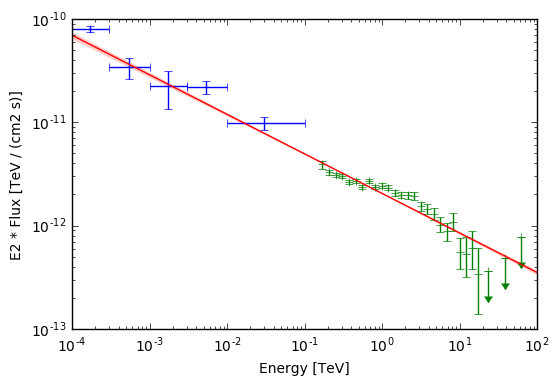

In [5]:
ax = flux_points_fermi.plot(sed_type='dnde', energy_power=2)
flux_points_gammacat.plot(ax=ax, energy_power=2)
result['best_fit_model'].plot(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2, color='r')
result['best_fit_model'].plot_error(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2, facecolor='r')

## Fit ECPL to HESS J0852-463 and 3FGL J0852.7-4631e

In [6]:
# add symmetric dnde_err
flux_points_gammacat =  gammacat['HESS J0852-463'].flux_points
flux_points_gammacat.table['dnde_err'] = flux_points_gammacat.table['dnde_errp']

source_fermi = fermi_3fgl['3FGL J0852.7-4631e']
flux_points_fermi =  compute_flux_points_dnde(source_fermi.flux_points, source_fermi.spectral_model)

# add symmetric dnde_err
flux_points_fermi.table['dnde_err'] = flux_points_fermi.table['dnde_errp']

pars = {}
pars['index'] = 2. * u.Unit('')
pars['amplitude'] = 1E-12 * u.Unit('cm-2 s-1 TeV-1')
pars['reference'] = 1. * u.TeV
pars['lambda_'] = 0. / u.TeV
ecpl = ExponentialCutoffPowerLaw(**pars)

result = fitter.run([flux_points_fermi, flux_points_gammacat], ecpl)

In [7]:
print(result['chi2_reduced'])

3.80194056305


(1e-13, 1e-10)

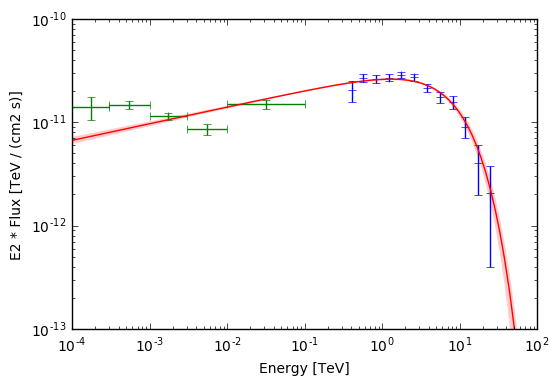

In [8]:
ax = flux_points_gammacat.plot(energy_power=2)
flux_points_fermi.plot(ax=ax, energy_power=2)
result['best_fit_model'].plot(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2, color='r')
result['best_fit_model'].plot_error(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2, facecolor='r')

ax.set_ylim(1E-13, 1E-10)

## Fit Log-Parabola to HESS J1507-622, 3FGL J1506.6-6219 and 3FHL J1507.9-6228

In [9]:
# add symmetric dnde_err
flux_points_gammacat =  gammacat['HESS J1507-622'].flux_points
flux_points_gammacat.table['dnde_err'] = flux_points_gammacat.table['dnde_errp']

source_fermi = fermi_3fgl['3FGL J1506.6-6219']
flux_points_fermi =  compute_flux_points_dnde(source_fermi.flux_points, source_fermi.spectral_model)

# add symmetric dnde_err
flux_points_fermi.table['dnde_err'] = flux_points_fermi.table['dnde_errp']

source_fermi_3fhl = fermi_3fhl['3FHL J1507.9-6228e']
flux_points_fermi_3fhl =  compute_flux_points_dnde(source_fermi_3fhl.flux_points, source_fermi_3fhl.spectral_model)

# add symmetric dnde_err
flux_points_fermi_3fhl.table['dnde_err'] = flux_points_fermi_3fhl.table['dnde_errp']


pars = {}
pars['alpha'] = 2. * u.Unit('')
pars['amplitude'] = 1E-12 * u.Unit('cm-2 s-1 TeV-1')
pars['reference'] = 1. * u.TeV
pars['beta'] = 0. * u.Unit('')
parab = LogParabola(**pars)

result = fitter.run([flux_points_fermi, flux_points_fermi_3fhl, flux_points_gammacat], parab)

In [10]:
print(result['chi2_reduced'])

1.43195842915


(1e-13, 1e-11)

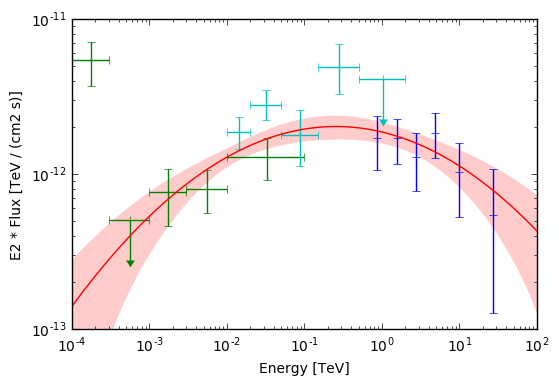

In [11]:
ax = flux_points_gammacat.plot(energy_power=2)
flux_points_fermi.plot(ax=ax, energy_power=2)
flux_points_fermi_3fhl.plot(ax=ax, energy_power=2)
result['best_fit_model'].plot(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2, color='r')
result['best_fit_model'].plot_error(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2, facecolor='r')

ax.set_ylim(1E-13, 1E-11)